In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from itertools import combinations
from scipy.stats import f_oneway, kendalltau, pearsonr, spearmanr

In [5]:
features = ['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT',
                'Z1000', 'Z200', 'ZBOT']

here = os.getcwd()
#
data_dir = os.path.join(here, 'io/data/train/')  # directory with the nc files
plots_dir = os.path.join(here, 'io/plots/')
stats_dir = os.path.join(here, 'io/stats/')

if not os.path.exists(data_dir):
    raise FileNotFoundError("data directory not found at", data_dir)

if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [ ]:
# calculate all correlations
combs = list(combinations(features, 2))
for i in range(len(combs)):
    comb = combs[i]
    print("loading data:", comb[0], comb[1], "...")
    feat_0_list = []
    feat_1_list = []

    for file in os.listdir(data_dir):
        path = os.path.join(data_dir, file)
        nc = Dataset(path)

        feat_0_list.append(nc.variables[comb[0]][:][0])
        feat_1_list.append(nc.variables[comb[1]][:][0])

    n = len(os.listdir(data_dir))

    feat_0 = np.vstack(feat_0_list).reshape((n, 768, 1152))
    feat_1 = np.vstack(feat_1_list).reshape((n, 768, 1152))

    corr = []
    assert (np.shape(feat_0) == np.shape(feat_1))
    print("calculating correlation coefficients for features ", comb[0], comb[1], "...")
    for row in range(len(feat_0[0, :, 0])):
        for col in range(len(feat_0[0, 0])):
            p_r = pearsonr(feat_0[:, row, col], feat_1[:, row, col])
            # s_r = spearmanr(tmq[:, row, col], u850[:, row, col])
            # k_t = kendalltau(tmq[:, row, col], u850[:, row, col])

            # pointcorr = ([p_r[0], s_r[0], k_t[0]])
            # corr.append(pointcorr)

            corr.append(p_r[0])

    corr_mat = np.reshape(corr, (768, 1152))
    print("saving ", comb[0], comb[1], "...")
    np.savetxt(os.path.join(stats_dir, "p_corr_" + comb[0] + "_" + comb[1] + ".csv"), corr_mat, delimiter=',')
    sns.heatmap(corr_mat)
    plt.savefig(plots_dir + "p_corr_" + comb[0] + "_" + comb[1] + ".png")
    plt.clf()

In [ ]:
# calculate anova scores
for feature in features:

    feat_0_list = []
    labels_list = []

    print("Loading data for ",feature, "...")
    for file in os.listdir(data_dir):
        path = os.path.join(data_dir, file)

        nc = Dataset(path)

        feat_0_list.append(nc.variables[feature])
        labels_list.append(nc.variables["LABELS"])

    n = len(os.listdir(data_dir))

    feat_0 = np.vstack(feat_0_list).reshape((n, 768, 1152))
    labels = np.vstack(labels_list).reshape((n, 768, 1152))

    anova = []

    print("Calculating anova...")
    for i in range(n):
        label_B_idx = np.where(labels[0] == 0)
        label_1_idx = np.where(labels[0] == 1)
        label_2_idx = np.where(labels[0] == 2)

        background = feat_0[i][(label_B_idx[0], label_B_idx[1])]
        label_1_data = feat_0[i][(label_1_idx[0], label_1_idx[1])]
        label_2_data = feat_0[i][(label_2_idx[0], label_2_idx[1])]

        anova.append(f_oneway(background, label_1_data, label_2_data).statistic)
    print("Saving...")
    np.savetxt(stats_dir + "anova_" + feature + ".csv", anova)

In [ ]:
anova = [file for file in os.listdir(stats_dir) if file.startswith("anova")]
anova_pd = pd.DataFrame()
for file in anova:
    name = file.replace(".csv", "").replace("anova_", "")
    data = pd.read_csv(stats_dir + file)
    anova_pd[name] = data

display(anova_pd.mean().sort_values())

In [ ]:
# calculate kendall coefficient
for feature in features:

    feat_0_list = []
    labels_list = []

    print("Loading data for ", feature, "...")
    for file in os.listdir(data_dir):
        path = os.path.join(data_dir, file)

        nc = Dataset(path)

        feat_0_list.append(nc.variables[feature])
        labels_list.append(nc.variables["LABELS"])

    n = len(os.listdir(data_dir))

    feat_0 = np.vstack(feat_0_list).reshape((n, 768 * 1152))

    kendall = []

    print("Calculating kendall...")
    for i in range(n):
        f = feat_0[i]
        l = labels_list[i]

        kendall.append(kendalltau(f, l)[0])
    print("Saving...")
    np.savetxt(stats_dir + "kendall_" + feature + ".csv", kendall)

In [ ]:
kendall = [file for file in os.listdir(stats_dir) if file.startswith("kendall")]
kendall_pd = pd.DataFrame()
for file in kendall:
    name = file.replace(".csv", "").replace("kendall_", "")
    data = pd.read_csv(stats_dir + file)
    kendall_pd[name] = data

display(kendall_pd.mean().sort_values())

In [51]:
files = os.listdir(stats_dir)
corrs = [file for file in files if file.startswith("p_corr")]
corr_mat_std = pd.DataFrame(columns=features, index=features, data=np.eye(16))
corr_mat_mean = pd.DataFrame(columns=features, index=features, data=np.eye(16))
corr_mat_med = pd.DataFrame(columns=features, index=features, data=np.eye(16))
for data in corrs:
    names = data.replace(".csv", "").replace("p_corr_", "").split(sep='_')
    corr_file = pd.read_csv(stats_dir + data)
    corr_mat_std.at[names[0], names[1]] = corr_file.abs().std().std()
    corr_mat_std.at[names[1], names[0]] = corr_file.abs().std().std()
    corr_mat_mean.at[names[0], names[1]] = corr_file.abs().mean().mean()
    corr_mat_mean.at[names[1], names[0]] = corr_file.abs().mean().mean()
    corr_mat_med.at[names[0], names[1]] = corr_file.abs().median().median()
    corr_mat_med.at[names[1], names[0]] = corr_file.abs().median().median()
corr_mat_std.to_csv(stats_dir + "corr_mat_std.csv")
corr_mat_mean.to_csv(stats_dir + "corr_mat_mean.csv")
corr_mat_med.to_csv(stats_dir + "corr_mat_med.csv")

100%|██████████| 120/120 [00:32<00:00,  3.68it/s]


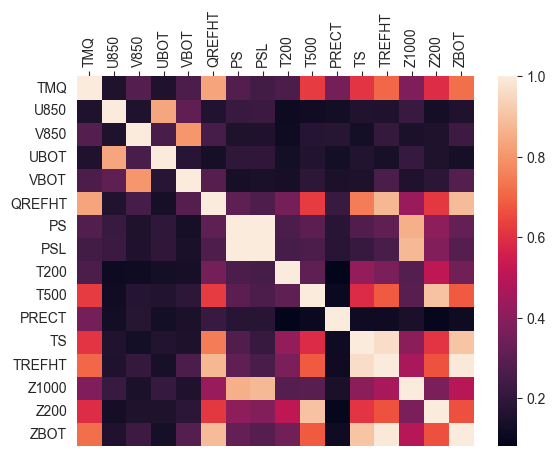

In [84]:
data = pd.read_csv(stats_dir+"corr_mat_med.csv")
# plot heatmap
ax = sns.heatmap(data.get(features), yticklabels=features, xticklabels=features)
ax.xaxis.tick_top()
for item in ax.get_xticklabels():
    item.set_rotation(90)

plt.savefig(plots_dir+'med_heatmap.png', dpi=100)
plt.show()